# Modeling True Positive and True Negative rates

We want to use the Bivariate Beta distribution built in the previous
sections. Before integrating it to the whole model, we consider a model for
sensibility and sensitivity as follows: 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ individuals who
were exposed to a disease, and $Y_n$ denote the number of negative tests in
$n_{neg}$ not exposed. The person is tested with a gold standard, which is the
best benchmark and the most accurate possible.

Remind that the sensitivity $\gamma_s$ is the probability of a test being positive given
the exposition, while the specificity $\gamma_e$ is the probability of a
negative test given the non-exposition. 
Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$. 
Besides that, there are two different models to handle with
$\alpha = (\alpha_1, \dots, \alpha_4)$. 

I. $\alpha_i \sim \operatorname{Gamma}(a^i, b^i)$, with $a^i$ and $b^i$ fixed. 

II. $\alpha_i \sim \operatorname{Dirac}(\hat{\alpha}_i)$ such that $\hat{\alpha}_i$
is calculated as explained before. 

In [1]:
import numpy as np
import pystan as ps

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

## Model 

First we code the model in Stan and use PyStan as a Python interface. 

In [3]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model.stan')
    with open('../models/sensitivity_specificity/spec_sens_model.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data and parameter blocks

Observe that we have a boolean variable to distinguish both models. 

In [4]:
print(sm.model_code[0:827])

data {
    int<lower = 0> n_pos;
    int<lower = 0> n_neg; 
    int Y_p;
    int Y_n;
    // Boolean variable to indicate whether alpha is known
    int<lower = 0, upper = 1> alpha_known; 
    // If alpha is known, length of a and b is 0
    vector<lower = 0>[alpha_known ? 0 : 4] a; 
    vector<lower = 0>[alpha_known ? 0 : 4] b;
    vector<lower = 0>[alpha_known ? 4 : 0] alpha_data;
}
parameters {
    vector<lower = 0>[alpha_known ? 0 : 4] alpha_param;
    simplex[4] U; 
}
transformed parameters{ 
    vector<lower=0>[4] alpha;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec; 
    // If alpha is known, get its data. It not, define the parameter. 
    if (alpha_known) {
        alpha = alpha_data;
    } else {
        alpha = alpha_param;
    }
    sens = U[1] + U[2];
    spec = U[1] + U[3];
}


### Model block 

In [5]:
print(sm.model_code[827:1089])


model {
    // Prior distributions for alpha if required.  
    if (!alpha_known) {
        for (i in 1:4) {
            alpha[i] ~ gamma(a[i], b[i]);
        }
    }

    U ~ dirichlet(alpha);
    Y_p ~ binomial(n_pos, sens);
    Y_n ~ binomial(n_neg, spec);
}


## Toy example 

First we need to test the model with fake data. This is done to verify how the it behaves in a controlled space. 

In [6]:
n_pos = 50
n_neg = 45

sens = 0.8 
spec = 0.9

Y_p = np.random.binomial(n = n_pos, p = sens)
Y_n = np.random.binomial(n = n_neg, p = spec)

m1, m2, v1, v2, rho = sens, spec, (0.05)**2, (0.05)**2, -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho, c = [1,1,1,1])

Notice that the estimated values are below: 

In [7]:
BivariateBeta().moments_calculus(solution.x)

(0.7605622599670436,
 0.8451216472124901,
 0.0028470020826766042,
 0.00204630495469627,
 -0.2401953043476225)

In [8]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_known": 1,
    "alpha_data": solution.x, 
    "a": [], 
    "b": [],
}

fit = sm.sampling(data=data, iter=10000, chains=4)

When the parameter `alpha_known = 1`, Stan code fixed `alpha = alpha_data`, a
fixed value. Because of that, the `alpha` parameters have `Rhat`and `n_eff`
being `nan`. 

In [9]:
fit

Inference for Stan model: anon_model_27cd10f06a7b45fec6f58c5ba16a0b3e.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                  mean se_mean      sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
U[1]              0.69  5.5e-4    0.05    0.59    0.65    0.69   0.72   0.77   7237    1.0
U[2]              0.12  3.8e-4    0.03    0.07     0.1    0.12   0.14   0.19   7214    1.0
U[3]              0.19  4.3e-4    0.04    0.12    0.17    0.19   0.22   0.27   7414    1.0
U[4]            2.8e-4  1.4e-5  1.5e-3 5.6e-17 8.7e-14 3.8e-10 1.4e-6 3.3e-3  11936    1.0
alpha[1]         38.14 5.0e-15 7.1e-15   38.14   38.14   38.14  38.14  38.14      2    1.0
alpha[2]          9.75     0.0     0.0    9.75    9.75    9.75   9.75   9.75      2    1.0
alpha[3]         15.08 3.8e-15 5.3e-15   15.08   15.08   15.08  15.08  15.08      2    1.0
alpha[4]        8.1e-7 7.5e-23 1.1e-22  8.1e-7  8.1e-7  8.1e-7 8.1e-7 8.1e-7     

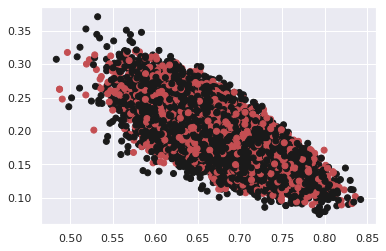

In [10]:
info = fit.to_dataframe()

plt.scatter(info['U[1]'], info['U[3]'], color = ['r' if info['divergent__'].loc[i] == 1 else 'k' for i in range(len(info))])
#az.plot_pair(fit, divergences = True, var_names=('U'))